<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Unsupervised%2BSemi-Supervised/Build_a_User_Based_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recommend items to users based on preferences of similar users using User-Based
Collaborative Filtering.

Load User-Item Rating Data

In [1]:
import requests
import zipfile
import os

url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_file_name = "ml-latest-small.zip"
extracted_dir_name = "ml-latest-small"

# Download the zip file
print(f"Downloading {zip_file_name}...")
response = requests.get(url)
if response.status_code == 200:
    with open(zip_file_name, "wb") as f:
        f.write(response.content)
    print(f"{zip_file_name} downloaded successfully.")

    # Extract the contents
    print(f"Extracting {zip_file_name}...")
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir_name)
    print(f"Contents extracted to {extracted_dir_name}.")

    # Clean up the zip file
    # os.remove(zip_file_name)
    # print(f"{zip_file_name} removed.")

else:
    print(f"Failed to download the file. Status code: {response.status_code}")


ml-latest-small.zip downloaded successfully.
Extracting ml-latest-small.zip...
Contents extracted to ml-latest-small.


In [3]:
import os

extracted_dir_name = "ml-latest-small"
print(os.listdir(extracted_dir_name))

['ml-latest-small']


In [4]:
import pandas as pd
import os

extracted_dir_name = "ml-latest-small"
nested_dir_name = "ml-latest-small"
ratings_file_path = os.path.join(extracted_dir_name, nested_dir_name, 'ratings.csv')
ratings_df = pd.read_csv(ratings_file_path)
print("Successfully loaded ratings.csv")
print(ratings_df.head())

Successfully loaded ratings.csv
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [5]:
display(ratings_df.head())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Compute User Similarity Matrix

In [6]:
from sklearn.metrics.pairwise import cosine_similarity

# Create a user-item matrix using pivot_table
user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Compute the cosine similarity between users
user_similarity_matrix = cosine_similarity(user_item_matrix)

# Convert the similarity matrix to a DataFrame for better readability
user_similarity_df = pd.DataFrame(user_similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User Similarity Matrix (first 5 users):")
display(user_similarity_df.head())

User Similarity Matrix (first 5 users):


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


## Define a function to get top similar users


In [7]:
def get_top_similar_users(target_user_id, user_similarity_df, n):
    """
    Finds the top N similar users for a given target user.

    Args:
        target_user_id (int): The ID of the target user.
        user_similarity_df (pd.DataFrame): The user-user similarity matrix.
        n (int): The number of top similar users to return.

    Returns:
        pd.Index: The index (user IDs) of the top N similar users.
    """
    # Get the similarity scores for the target user
    user_similarities = user_similarity_df[target_user_id]

    # Sort the similarity scores in descending order and exclude the target user
    sorted_similarities = user_similarities.sort_values(ascending=False)
    top_similar_users = sorted_similarities.drop(target_user_id).head(n)

    return top_similar_users.index

# Example usage (optional - can be removed if not needed for immediate testing)
# target_user = 1
# num_similar_users = 5
# top_users = get_top_similar_users(target_user, user_similarity_df, num_similar_users)
# print(f"Top {num_similar_users} similar users for user {target_user}: {list(top_users)}")

## Define a function to predict ratings




In [8]:
def predict_rating(target_user_id, item_id, ratings_df, user_similarity_df, n):
    """
    Predicts the rating for a target user on a specific item using user-based collaborative filtering.

    Args:
        target_user_id (int): The ID of the target user.
        item_id (int): The ID of the item for which to predict the rating.
        ratings_df (pd.DataFrame): The DataFrame containing user ratings.
        user_similarity_df (pd.DataFrame): The user-user similarity matrix.
        n (int): The number of top similar users to consider for prediction.

    Returns:
        float: The predicted rating for the target user on the item, or 0 if no similar users have rated the item.
    """
    # Get the top n similar users
    top_similar_users_ids = get_top_similar_users(target_user_id, user_similarity_df, n)

    # Filter ratings to include only those from top similar users
    similar_users_ratings = ratings_df[ratings_df['userId'].isin(top_similar_users_ids)]

    # Filter for ratings of the specific item
    item_ratings_by_similar_users = similar_users_ratings[similar_users_ratings['movieId'] == item_id]

    # If no similar users have rated the item, return 0 or a default value
    if item_ratings_by_similar_users.empty:
        return 0.0

    # Calculate the weighted average of ratings
    weighted_sum = 0
    similarity_sum = 0

    for index, row in item_ratings_by_similar_users.iterrows():
        similar_user_id = row['userId']
        rating = row['rating']
        similarity = user_similarity_df.loc[target_user_id, similar_user_id]

        weighted_sum += similarity * rating
        similarity_sum += similarity

    # Avoid division by zero if all similarities are 0
    if similarity_sum == 0:
        return 0.0

    predicted_rating = weighted_sum / similarity_sum

    return predicted_rating

# Example usage (optional - can be removed if not needed for immediate testing)
# target_user_to_predict = 1
# item_to_predict = 296  # Example item ID (Pulp Fiction)
# num_similar_users_for_prediction = 10

# predicted_rating_value = predict_rating(target_user_to_predict, item_to_predict, ratings_df, user_similarity_df, num_similar_users_for_prediction)
# print(f"Predicted rating for user {target_user_to_predict} on item {item_to_predict}: {predicted_rating_value}")

## Test the prediction function


In [12]:
# 1. Select a target user and an item they haven't rated
target_user_id = 1
# Find items rated by the target user
rated_items_by_target_user = ratings_df[ratings_df['userId'] == target_user_id]['movieId'].unique()
# Find an item not rated by the target user
all_movie_ids = ratings_df['movieId'].unique()
unrated_items = [item for item in all_movie_ids if item not in rated_items_by_target_user]

# Select the first unrated item as the target item (or choose a specific one if preferred)
if unrated_items:
    item_to_predict = unrated_items[0]
else:
    # Handle the case where the user has rated all items (unlikely in this dataset)
    item_to_predict = None
    print(f"User {target_user_id} has rated all available items.")


if item_to_predict is not None:
    # 2. Call the predict_rating function
    num_similar_users_for_prediction = 10
    predicted_rating_value = predict_rating(target_user_id, item_to_predict, ratings_df, user_similarity_df, num_similar_users_for_prediction)

    # 4. Print the target_user_id, item_id, and the predicted rating
    print(f"Target User ID: {target_user_id}")
    print(f"Item ID to Predict: {item_to_predict}")
    print(f"Predicted Rating: {predicted_rating_value}")

Target User ID: 1
Item ID to Predict: 318
Predicted Rating: 3.732186608627112


## Split the data


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (80668, 4)
Testing set shape: (20168, 4)


## Make predictions on the test set



In [11]:
predicted_ratings = []
for index, row in test_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    # Use train_df for prediction as the model is built on training data
    predicted_rating = predict_rating(user_id, movie_id, train_df, user_similarity_df, 10)
    predicted_ratings.append(predicted_rating)

# Convert the list to a pandas Series
predicted_ratings = pd.Series(predicted_ratings)

## Calculate rmse and mae


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df['rating'], predicted_ratings))

# Calculate MAE
mae = mean_absolute_error(test_df['rating'], predicted_ratings)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Root Mean Squared Error (RMSE): 1.7519327909304334
Mean Absolute Error (MAE): 1.2434974453347631


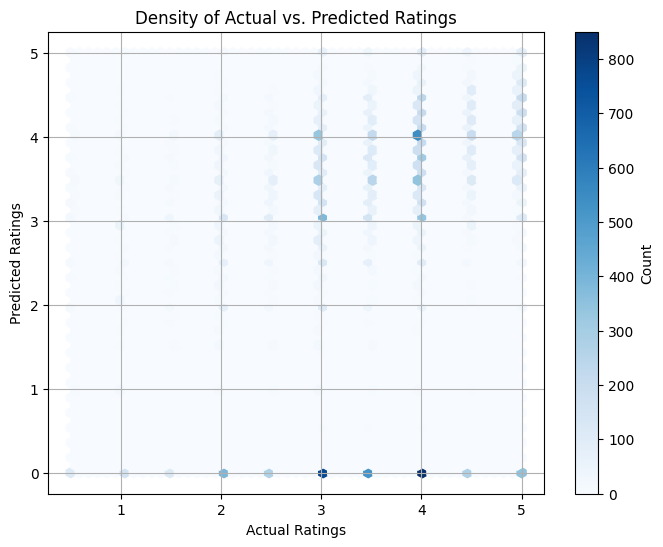

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a hexbin plot to visualize the density of actual vs. predicted ratings
plt.figure(figsize=(8, 6))
plt.hexbin(test_df['rating'], predicted_ratings, gridsize=50, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Density of Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()

## Prepare data for deep learning



In [23]:
# Create mappings for user and movie IDs
unique_users = ratings_df['userId'].unique()
unique_movies = ratings_df['movieId'].unique()

user_to_encoded = {user: i for i, user in enumerate(unique_users)}
movie_to_encoded = {movie: i for i, movie in enumerate(unique_movies)}

# Add encoded columns to train_df and test_df
train_df['user_encoded'] = train_df['userId'].map(user_to_encoded)
train_df['movie_encoded'] = train_df['movieId'].map(movie_to_encoded)

test_df['user_encoded'] = test_df['userId'].map(user_to_encoded)
test_df['movie_encoded'] = test_df['movieId'].map(movie_to_encoded)

# Store the number of unique users and movies
num_users = len(unique_users)
num_movies = len(unique_movies)

print(f"Number of unique users: {num_users}")
print(f"Number of unique movies: {num_movies}")
display(train_df.head())
display(test_df.head())

Number of unique users: 610
Number of unique movies: 9724


,userId,movieId,rating,timestamp,user_encoded,movie_encoded
80568,509,7347,3.0,1435994597,508,4285
50582,326,71462,4.0,1322252335,325,5629
8344,57,2115,3.0,965798155,56,134
99603,610,1127,4.0,1479544102,609,66
71701,462,2409,2.0,1174438249,461,1172


,userId,movieId,rating,timestamp,user_encoded,movie_encoded
67037,432,77866,4.5,1335139641,431,4730
42175,288,474,3.0,978465565,287,474
93850,599,4351,3.0,1498524542,598,2631
6187,42,2987,4.0,996262677,41,194
12229,75,1610,4.0,1158989841,74,727


## Build the deep learning model


In [29]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

# Define input layers for users and items
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

In [30]:
# Define embedding dimensions
embedding_dim = 50

# Create embedding layers for users and items
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=num_movies, output_dim=embedding_dim, name='item_embedding')(item_input)

# Flatten the embedding layers
user_flatten = Flatten()(user_embedding)
item_flatten = Flatten()(item_embedding)

# Concatenate the flattened embeddings
concat_embeddings = concatenate([user_flatten, item_flatten])

In [31]:
# Add dense layers
dense_layer_1 = Dense(128, activation='relu')(concat_embeddings)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)

# Output layer
output_layer = Dense(1, activation='linear')(dense_layer_2)

# Create the model
model = Model(inputs=[user_input, item_input], outputs=output_layer)

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     30,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │    486,200 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 537,949 (2.05 MB)

 Trainable params: 537,949 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model


In [32]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit([train_df['user_encoded'], train_df['movie_encoded']],
                    train_df['rating'],
                    epochs=10,
                    batch_size=64,
                    validation_data=([test_df['user_encoded'], test_df['movie_encoded']], test_df['rating']))

print("Model training completed.")

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 2.1217 - val_loss: 0.7842
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.7001 - val_loss: 0.7638
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6324 - val_loss: 0.7573
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.5833 - val_loss: 0.7860
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 0.5091 - val_loss: 0.8172
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.4440 - val_loss: 0.8528
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.3741 - val_loss: 0.8680
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.3290 - val_loss: 0.8662
Epoch 9/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.2845 - val_loss: 0.8837
Epoch 10/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.2504 - val_loss: 0.9017
Model training completed.


## Evaluate the deep learning model



In [33]:
# Make predictions on the test set
predicted_ratings_dl = model.predict([test_df['user_encoded'], test_df['movie_encoded']])

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for the deep learning model
rmse_dl = np.sqrt(mean_squared_error(test_df['rating'], predicted_ratings_dl))

# Calculate MAE for the deep learning model
mae_dl = mean_absolute_error(test_df['rating'], predicted_ratings_dl)

# Print the results
print(f"Deep Learning Model - Root Mean Squared Error (RMSE): {rmse_dl}")
print(f"Deep Learning Model - Mean Absolute Error (MAE): {mae_dl}")

# Compare with previous results (assuming RMSE and MAE from previous model are available as rmse and mae)
print("\nComparison with User-Based Collaborative Filtering:")
print(f"User-Based CF - RMSE: {rmse}")
print(f"User-Based CF - MAE: {mae}")

Deep Learning Model - Root Mean Squared Error (RMSE): 0.9495818288934658
Deep Learning Model - Mean Absolute Error (MAE): 0.7230221486211899

Comparison with User-Based Collaborative Filtering:
User-Based CF - RMSE: 1.7519327909304334
User-Based CF - MAE: 1.2434974453347631


## Visualize Deep Learning Model Predictions


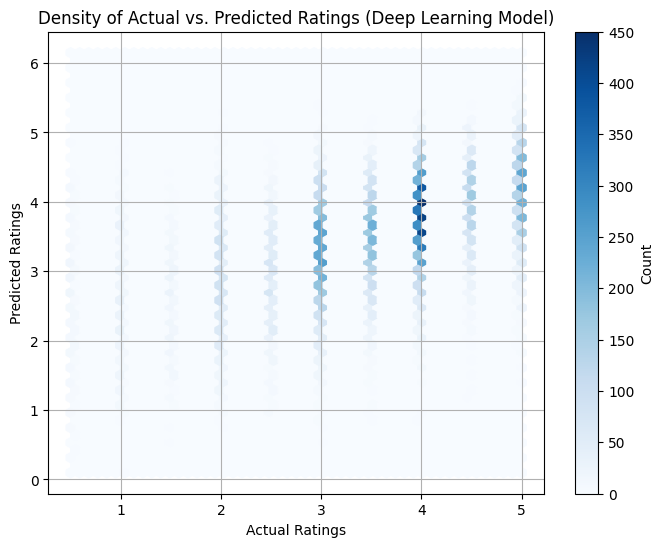

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a hexbin plot for actual vs. predicted ratings from the deep learning model
plt.figure(figsize=(8, 6))
plt.hexbin(test_df['rating'], predicted_ratings_dl.flatten(), gridsize=50, cmap='Blues')
plt.colorbar(label='Count')
plt.title('Density of Actual vs. Predicted Ratings (Deep Learning Model)')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.grid(True)
plt.show()